In [67]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 

from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader

In [68]:
#Choose Raw Event File
input_path_raw = "marker.raw"

# open a file
record_raw = RawReader(input_path_raw)
print(record_raw)  # show some metadata

#Get Events
events = record_raw.load_n_events(1000)  # load next n events
events_by_time = record_raw.load_delta_t(10000)  # load the next 10ms of data

RawReader(marker.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 100000000


In [69]:
#Extract Event Data Coordinates
y_values = events['y']
x_values = events['x']

#Create Additional Parameters
#theta = np.linspace(0,359,num=360)
#rho = np.zeros((theta.shape[0],x_values.shape[0]))

height, width = record_raw.get_size()
#theta


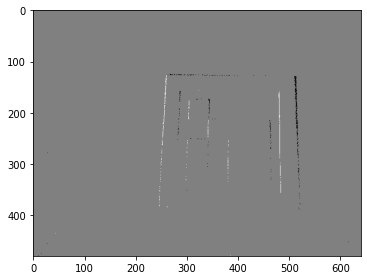

In [70]:
#Visualize Events (Not necessary for functionality)
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

im = viz_events(events, height, width)

np.savetxt('myfile.csv', im[:,:,1], delimiter=',')

plt.imshow(im)
plt.tight_layout()

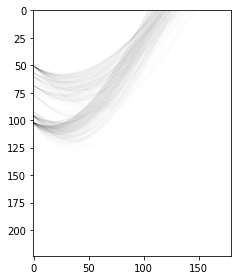

In [71]:
#Hough Transform Lines

#Note floor rounds values down, all values are rounded down in this section
#Decrease theta_res for increased degree accuracy
#Increase rho_scale for increased rho accuracy
#Note accuracy increases result in larger computational load

theta_res = 1                                           #Spacing between theta values (in degrees)
thetas = np.arange(0,180,theta_res)                     #Theta vector
rho_scale = 0.2                                        #Rho scaling for accumulator array (1 will give 1 index, or pixel, per integer rho value)
rho_max = int(np.floor((height + width)*rho_scale))     #Largest possible rho value (derived from rho equation)
H = np.zeros((rho_max,thetas.shape[0]))                 #Accumulator array


#Loop through each event and incrementally increase rho values in accumulator array
for i in range(1000):  
    for j in range(0,thetas.shape[0]):
        rho = int(np.floor((x_values[i]*np.cos(np.deg2rad(j)) + y_values[i] * np.sin(np.deg2rad(j)))*rho_scale))
        if rho > 0:
            rho_index = int(np.floor(rho))
            H[rho][j] = H[rho][j]+1

plt.imshow(H, cmap = 'binary')
plt.tight_layout()


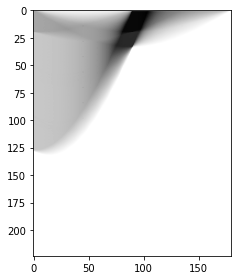

In [56]:
#Traditional Image Hough Transform
#image size limited to 100x100 right now for computation purposes
for i in range(100): 
    for k in range(100): 
        for j in range(0,thetas.shape[0]):
            rho = int(np.floor((k*np.cos(np.deg2rad(j)) + i* np.sin(np.deg2rad(j)))*rho_scale))
            if rho > 0:
                rho_index = int(np.floor(rho))
                H[rho][j] = H[rho][j]+1

plt.imshow(H, cmap = 'binary')
plt.tight_layout()

In [66]:
# Test attempt at circular hough transform
# Initial tests reveal several semi-cencentric circles along all polarity net change, not current frame change

# to get a single 'time frame' load next 10 ms of data together and build an image like this

img1 = cv2.imread('circle.jpg',0)
img1 = cv2.medianBlur(img1,9)
cimg = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img1,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',cimg)
plt.imshow(cimg)

error: OpenCV(4.5.5) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0xa96199bf::Set<3,4,-1>,struct cv::impl::A0xa96199bf::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [62]:
#attempt 2 circle hough

height, width = record_raw.get_size()

#  iteration
# load 10M events by batches of 50ms:
while not record_raw.is_done() and record_raw.current_event_index() < 1E7:
    # load the next 50 ms worth of events
    events = record_raw.load_delta_t(50000)
    
    im = viz_events(events, height, width)
    img1 = cv2.medianBlur(img1,9)
    cimg = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img1,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)



plt.imshow(im)
plt.tight_layout()
cv2.imwrite('circle.jpg',im)

error: OpenCV(4.5.5) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0xa96199bf::Set<3,4,-1>,struct cv::impl::A0xa96199bf::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3
